In [69]:
import numpy as np
import pandas as pd
import glob
import pickle
import matplotlib.pyplot as plt
import sys
import os
import math
import gc
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from pathlib import Path
import japanize_matplotlib
from pathlib import Path
import re
import csv
from scipy.io import loadmat


In [70]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df


def decimate_to_30Hz(df):
    df = df.copy()

    # 1 / 30 = 0.033333... 秒
    dt = 1.0 / 30.0

    # 30Hz 相当になるように time を丸める
    df['time'] = (df['time'] / dt).round() * dt

    # 重複した time は後勝ちで間引く
    df = df.drop_duplicates(subset='time', keep='last')

    # time で整列
    df = df.sort_values('time').reset_index(drop=True)

    return df



def estimate_sampling_rate(df):
    t = df['time'].values

    # 時刻差分（dt）を計算
    dt = np.diff(t)

    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]

    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)

    # sampling rate [Hz]
    fs = 1.0 / dt_med

    return fs, dt_med

In [71]:
seat_path = "1_takemura2_2F.csv"
pedal_path = "pedal_20251106_1744090.csv"
cop_path = "seat_20251106_1744090.csv"
steer_path = "steer_20251106_1744090.csv"
df_seat = pd.read_csv(seat_path,skiprows=1)
df_pedal = pd.read_csv(pedal_path,skiprows=21)
df_cop = pd.read_csv(cop_path,skiprows=21)
df_steer = pd.read_csv(steer_path,skiprows=21)

In [72]:
df_pedal.rename(columns={'Untitled 4':'pedal'},inplace=True)
df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
df_cop.rename(columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)
df_pedal = make_time_row(df_pedal)
df_steer = make_time_row(df_steer)
df_cop = make_time_row(df_cop)


df_seat['time'] = df_seat['時間']
fs, dt = estimate_sampling_rate(df_seat)
print("Sampling rate:", fs, "Hz")

print(len(df_pedal),len(df_steer),len(df_cop))


display(df_seat.head(2))
# display(df_pedal.head(2))
# display(df_cop.head(2))
# display(df_steer.head(2))
df_mock = pd.merge(df_cop[['time','COP_X','COP_Y']], df_steer[['time','steer','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
df_mock = pd.merge(df_mock, df_pedal[['time','pedal']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 

df_mock2 = decimate_to_30Hz(df_mock[(df_mock['time'] >=14.45)&(df_mock['time']<225.25)].copy())
df_mock2 = decimate_to_30Hz(df_mock.copy())
df_mock2['time'] -= df_mock2['time'].iloc[0]
df_seat2 = decimate_to_30Hz(df_seat.copy())

print(len(df_mock2),len(df_seat2))

df_all = pd.merge(df_mock2, df_seat2, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 


Sampling rate: 41.66666666666509 Hz
24965 24983 24983


,フレーム,日付,時間,センサー,閾値,センサー･パッド,行,列,平均圧力,最低圧力,...,列.1,平均圧力.1,最低圧力.1,ピーク圧力.1,接触域 (cm²).1,選択領域(cm²).1,接触 %.1,圧力中心行.1,圧力中心列.1,time
0,1,2025 11 06,0.000,N/cm²,0.13,PX100:40.40.02 S0162,40,40,0.3,0.13,...,36,0.74,0.13,3.08,1200.00,2090.32,57.41,23.53,16.14,0.000
1,2,2025 11 06,0.024,N/cm²,0.13,PX100:40.40.02 S0162,40,40,0.3,0.13,...,36,0.73,0.13,3.06,1203.23,2090.32,57.56,23.51,15.96,0.024


7496 6694


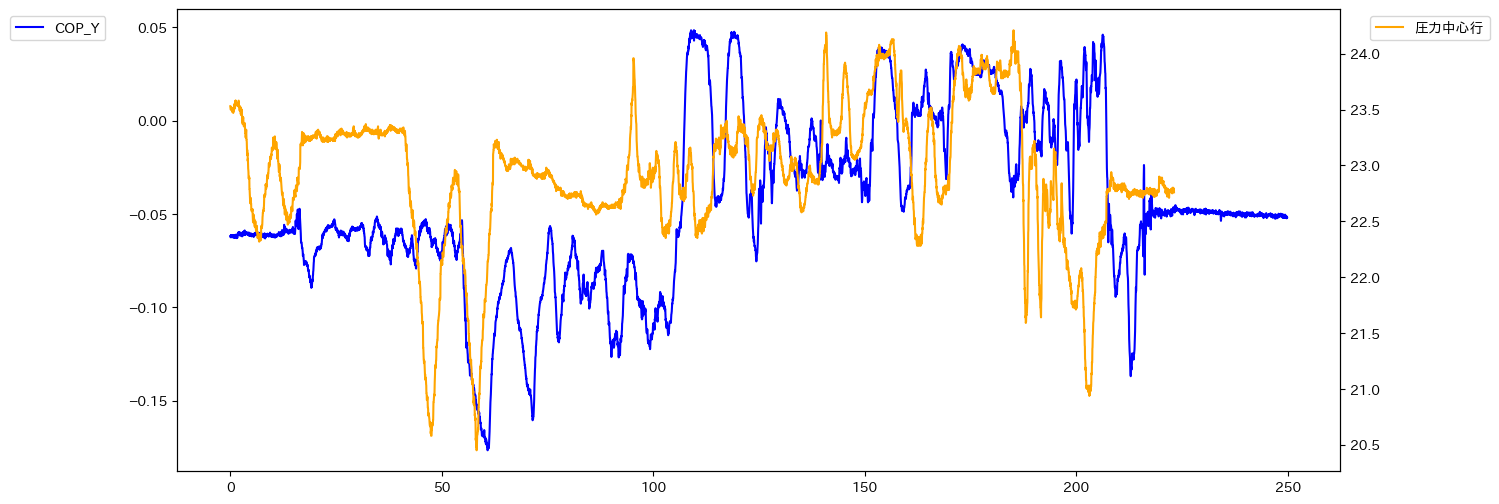

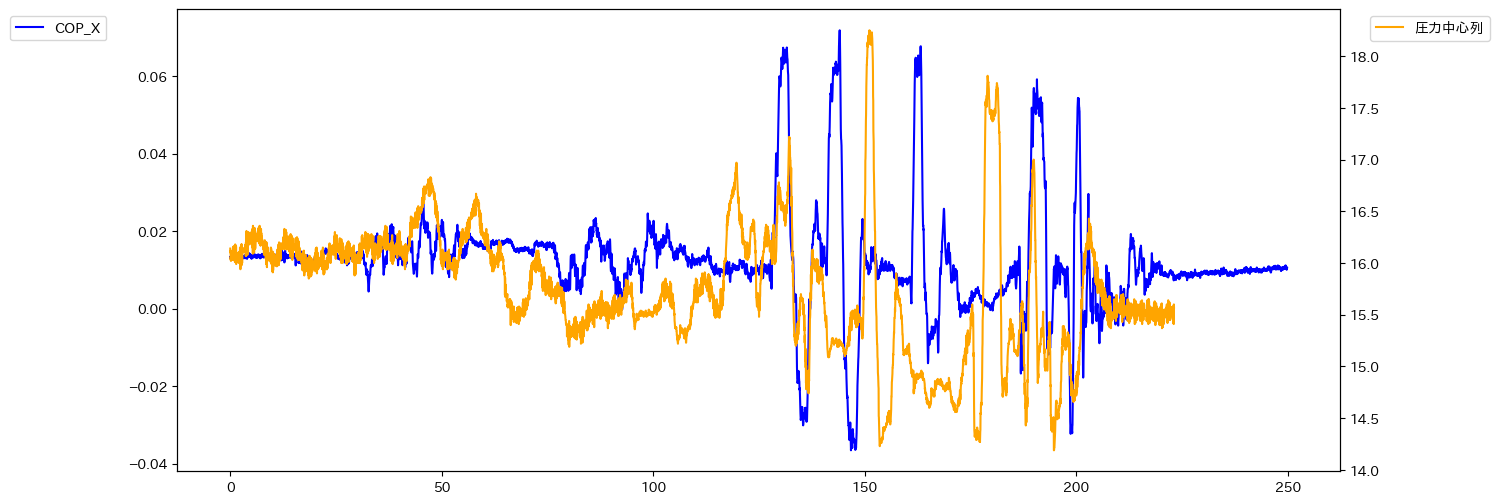

In [73]:

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['COP_Y'],color='blue',label='COP_Y')
ax2.plot(df_all['time'],df_all['圧力中心行.1'],color='orange',label='圧力中心行') 
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['COP_X'],color='blue',label='COP_X')
ax2.plot(df_all['time'],df_all['圧力中心列.1'],color='orange',label='圧力中心列') # Y
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

In [77]:
def plot_shifted_cop(df, shift_samples):
    # シフトした列を追加
    df_plot = df.copy()
    df_plot["COP_Y_shift"] = df_plot["COP_Y"].shift(shift_samples)
    df_plot["COP_X_shift"] = df_plot["COP_X"].shift(shift_samples)

    # === COP_Y vs 圧力中心行 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_Y_shift'], color='blue', label=f'COP_Y (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心行.1'], color='orange', label='圧力中心行')

    ax1.set_title(f"COP_Y Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    # === COP_X vs 圧力中心列 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_X_shift'], color='blue', label=f'COP_X (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心列.1'], color='orange', label='圧力中心列')

    ax1.set_title(f"COP_X Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    return df_plot


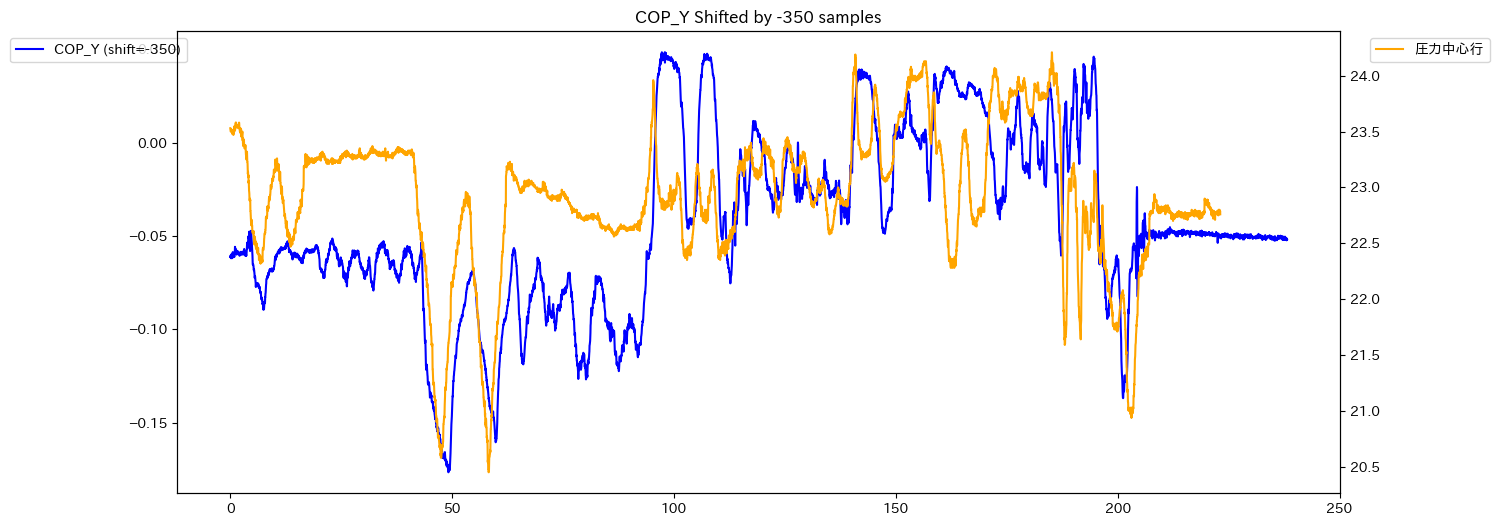

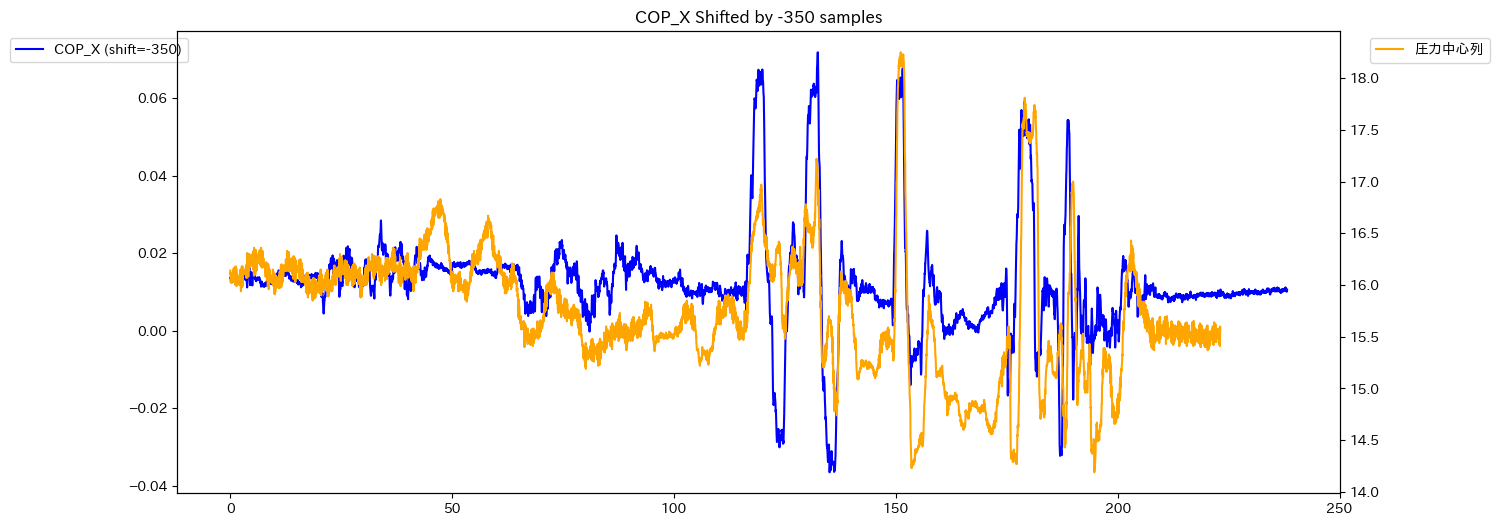

In [78]:
df_shift = plot_shifted_cop(df_all, shift_samples=-350)

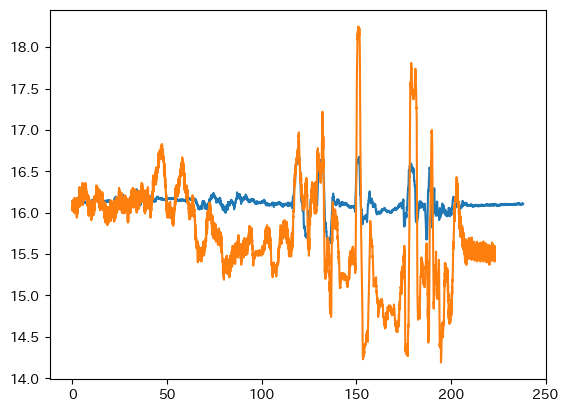

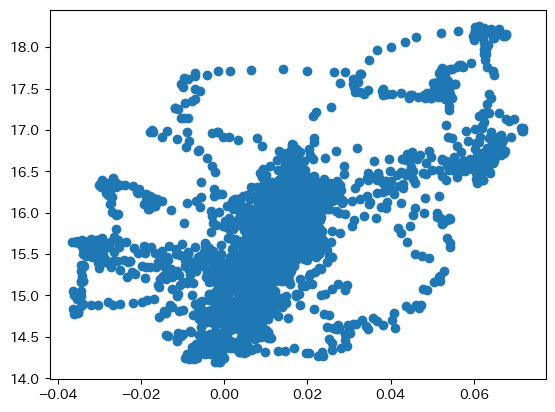

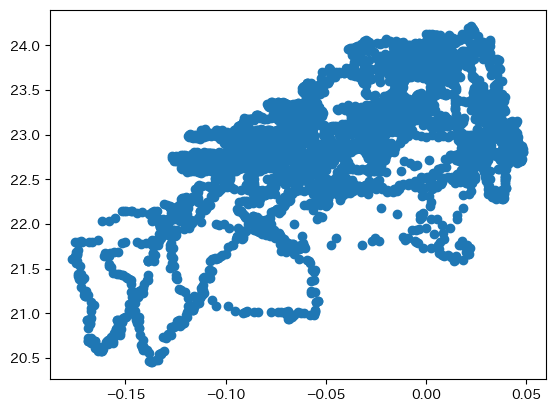

In [ ]:
plt.scatter(df_shift['COP_X_shift'], df_shift['圧力中心列.1'])
plt.show()
plt.scatter(df_shift['COP_Y_shift'], df_shift['圧力中心行.1'])


scale: 0.030383023412328816
R:
 [[ 0.8868982   0.46196491]
 [-0.46196491  0.8868982 ]]
t: [-0.73358425 -0.43988844]


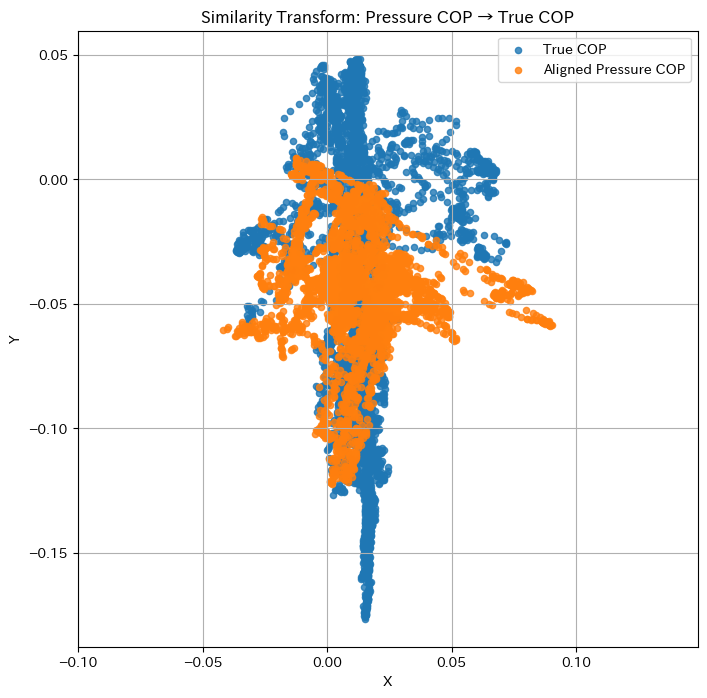

In [93]:
import numpy as np

def estimate_similarity_transform(src, dst):
    """
    src → dst の相似変換（scale + rotation + translation）
    SVDが収束しない問題を避ける robust 版
    """
    src = np.asarray(src)
    dst = np.asarray(dst)

    # --- NaN / Inf 除去 ---
    mask = ~np.isnan(src).any(axis=1) & ~np.isnan(dst).any(axis=1)
    src = src[mask]
    dst = dst[mask]

    # --- 平均でセンタリング ---
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)
    src_c = src - src_mean
    dst_c = dst - dst_mean

    # --- SVD（重心あり版なので壊れない） ---
    H = src_c.T @ dst_c
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # 反転補正
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # スケール
    scale = (S.sum()) / (src_c**2).sum()

    # 平行移動
    t = dst_mean - scale * (R @ src_mean)

    return scale, R, t

def apply_similarity(src, scale, R, t):
    return (scale * (R @ src.T)).T + t

# ====== あなたのデータ ======
pressure = df_shift[['圧力中心列.1', '圧力中心行.1']].values
cop_true = df_shift[['COP_X_shift', 'COP_Y_shift']].values

# ====== 変換推定 ======
scale, R, t = estimate_similarity_transform(pressure, cop_true)
aligned = apply_similarity(pressure, scale, R, t)

print("scale:", scale)
print("R:\n", R)
print("t:", t)

# ====== プロット ======
plt.figure(figsize=(8, 8))
plt.scatter(cop_true[:, 0], cop_true[:, 1], label="True COP", alpha=0.8, s=20)
plt.scatter(aligned[:, 0], aligned[:, 1], label="Aligned Pressure COP", alpha=0.8, s=20)

plt.legend()
plt.title("Similarity Transform: Pressure COP → True COP")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)

plt.show()

scale: 0.030383023412328816
R:
 [[ 0.8868982   0.46196491]
 [-0.46196491  0.8868982 ]]
t (anchor-based): [-0.74830821 -0.46939192]


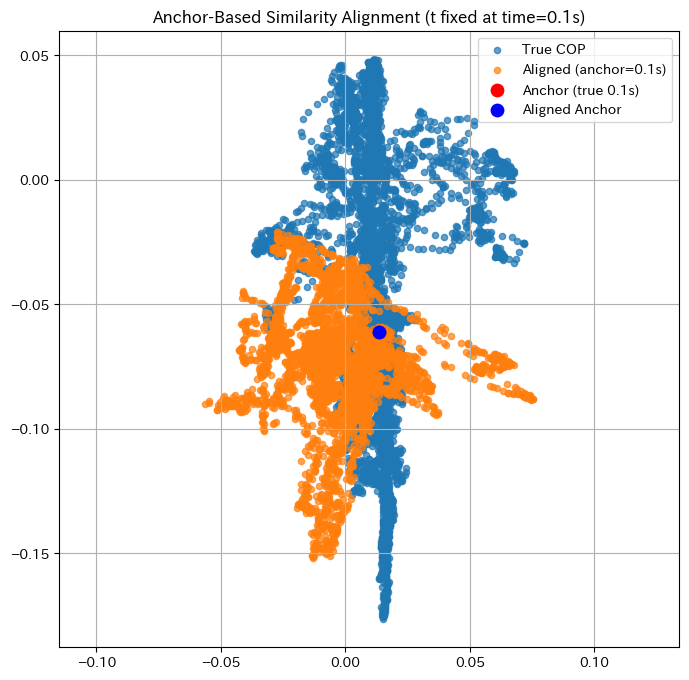

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_rotation_scale(src, dst):
    """
    相似変換のうち、rotation + scale のみを robust-SVD で推定。
    translation（平行移動）は推定しない。
    """
    src = np.asarray(src)
    dst = np.asarray(dst)

    # --- NaN / Inf 除去 ---
    mask = ~np.isnan(src).any(axis=1) & ~np.isnan(dst).any(axis=1)
    src = src[mask]
    dst = dst[mask]

    # --- 重心でセンタリング ---
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    src_c = src - src_mean
    dst_c = dst - dst_mean

    # --- SVD（重心あり）---
    H = src_c.T @ dst_c
    U, S, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # --- scale ---
    scale = (S.sum()) / (src_c**2).sum()

    return scale, R


def apply_with_anchor(src, scale, R, X0, Z0):
    """
    平行移動はアンカーで固定：
    t = Z0 - scale * R * X0
    """
    t = Z0 - scale * (R @ X0)
    transformed = (scale * (R @ src.T)).T + t
    return transformed, t


# ====== ここからあなたのデータ ======

pressure = df_shift[['圧力中心列.1', '圧力中心行.1']].values
cop_true = df_shift[['COP_X_shift', 'COP_Y_shift']].values

# --- time=0.1s の index ---
idx = np.argmin(np.abs(df_shift['time'] - 0.1))

X0 = pressure[idx]   # アンカー：圧力COP
Z0 = cop_true[idx]   # アンカー：本物COP

# --- 回転・スケール推定（平行移動なし） ---
scale, R = estimate_rotation_scale(pressure, cop_true)

# --- アンカー固定の平行移動を適用 ---
aligned, t = apply_with_anchor(pressure, scale, R, X0, Z0)

print("scale:", scale)
print("R:\n", R)
print("t (anchor-based):", t)

# ====== プロット ======
plt.figure(figsize=(8, 8))
plt.scatter(cop_true[:, 0], cop_true[:, 1], label="True COP", alpha=0.7, s=20)
plt.scatter(aligned[:, 0], aligned[:, 1], label="Aligned (anchor=0.1s)", alpha=0.7, s=20)

# アンカー点のプロット
plt.scatter(Z0[0], Z0[1], color="red", s=80, label="Anchor (true 0.1s)")
plt.scatter(aligned[idx, 0], aligned[idx, 1], color="blue", s=80, label="Aligned Anchor")

plt.legend()
plt.axis("equal")
plt.grid(True)
plt.title("Anchor-Based Similarity Alignment (t fixed at time=0.1s)")
plt.show()


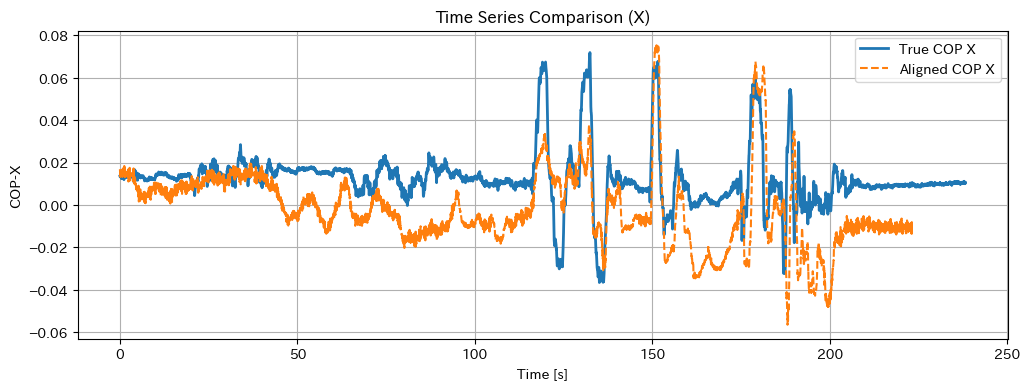

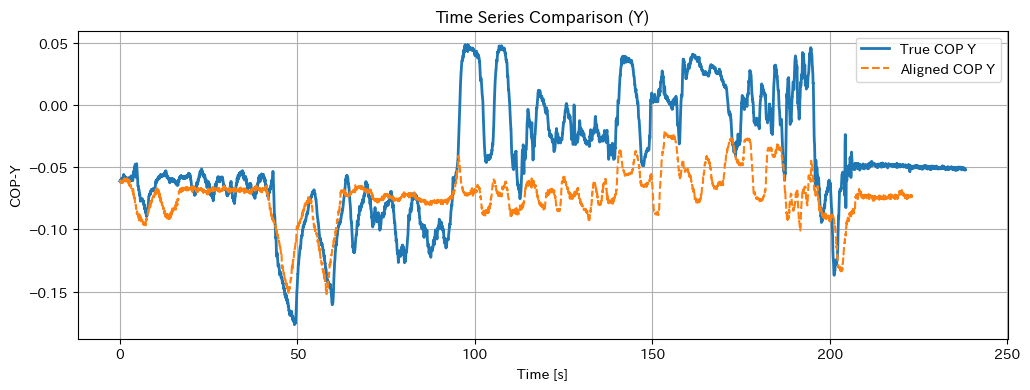

In [ ]:

time = df_shift['time'].values  # 時間軸

# === 時系列プロット：COP-X ===
plt.figure(figsize=(12,4))
plt.plot(time, cop_true[:,0], label="True COP X", linewidth=2)
plt.plot(time, aligned[:,0], label="Aligned COP X", linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("COP-X")
plt.title("Time Series Comparison (X)")
plt.grid(True)
plt.legend()
plt.show()

# === 時系列プロット：COP-Y ===
plt.figure(figsize=(12,4))
plt.plot(time, cop_true[:,1], label="True COP Y", linewidth=2)
plt.plot(time, aligned[:,1], label="Aligned COP Y", linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("COP-Y")
plt.title("Time Series Comparison (Y)")
plt.grid(True)
plt.legend()
plt.show()


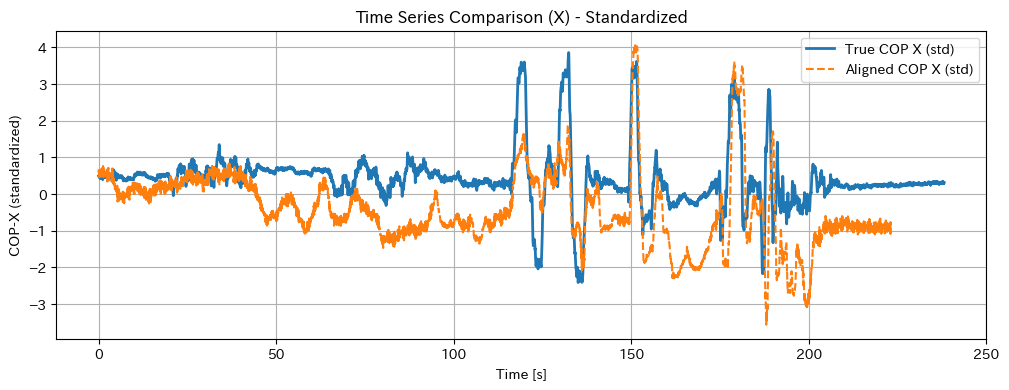

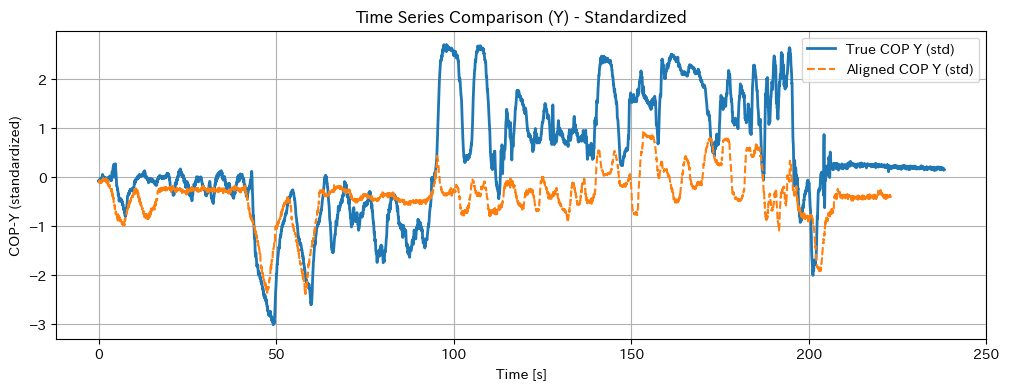

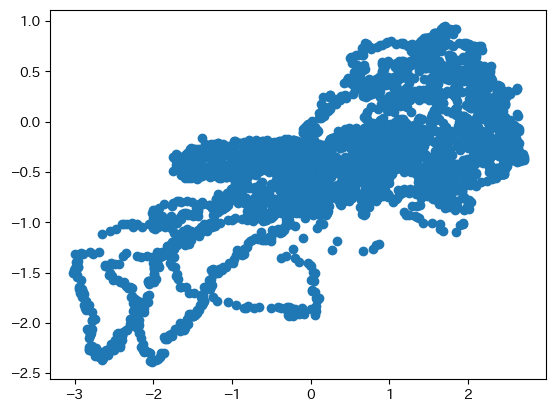

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- 時間軸 ---
time = df_shift['time'].values

# --- 元データ ---
X_true = cop_true.copy()
X_aligned = aligned.copy()

# --- 2系列を縦に結合して同じ scaler を使う（重要） ---
X_concat = np.vstack([X_true, X_aligned])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_concat)

# --- 元の2系列に戻す ---
n = len(X_true)
X_true_std = X_scaled[:n]
X_aligned_std = X_scaled[n:]

# ======== 時系列プロット（標準化後） ========

# === COP-X ===
plt.figure(figsize=(12,4))
plt.plot(time, X_true_std[:,0], label="True COP X (std)", linewidth=2)
plt.plot(time, X_aligned_std[:,0], label="Aligned COP X (std)", linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("COP-X (standardized)")
plt.title("Time Series Comparison (X) - Standardized")
plt.grid(True)
plt.legend()
plt.show()

# === COP-Y ===
plt.figure(figsize=(12,4))
plt.plot(time, X_true_std[:,1], label="True COP Y (std)", linewidth=2)
plt.plot(time, X_aligned_std[:,1], label="Aligned COP Y (std)", linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("COP-Y (standardized)")
plt.title("Time Series Comparison (Y) - Standardized")
plt.grid(True)
plt.legend()
plt.show()


plt.scatter(X_true_std[:,1],X_aligned_std[:,1])


In [100]:
print("NaN in pressure:", np.isnan(pressure).sum())
print("NaN in cop_true:", np.isnan(cop_true).sum())
print("NaN in aligned:", np.isnan(aligned).sum())
print("NaN in X_true_std:", np.isnan(X_true_std).sum())
print("NaN in X_aligned_std:", np.isnan(X_aligned_std).sum())
# === まず NaN を一括除去（X, Y, time を同期） ===

mask = ~np.isnan(cop_true).any(axis=1) & ~np.isnan(aligned).any(axis=1)

cop_true_clean = cop_true[mask]
aligned_clean  = aligned[mask]
time_clean     = time[mask]

print("After cleaning:")
print("  cop_true:", cop_true_clean.shape)
print("  aligned :", aligned_clean.shape)
print("  time    :", time_clean.shape)


NaN in pressure: 1604
NaN in cop_true: 700
NaN in aligned: 1604
NaN in X_true_std: 700
NaN in X_aligned_std: 1604
After cleaning:
  cop_true: (6694, 2)
  aligned : (6694, 2)
  time    : (6694,)


In [102]:
from sklearn.preprocessing import StandardScaler

X_concat = np.vstack([cop_true_clean, aligned_clean])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_concat)

n = len(cop_true_clean)
X_true_std    = X_scaled[:n]
X_aligned_std = X_scaled[n:]


MSE COP X: 0.6257636585050147
MSE COP Y: 0.8814062160155517


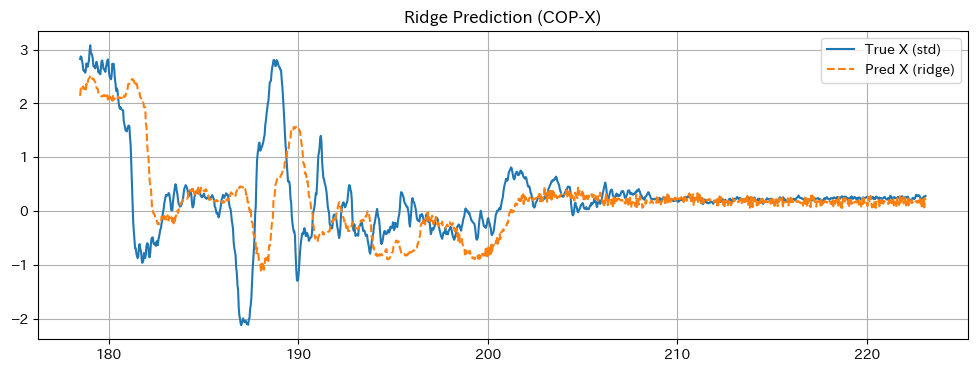

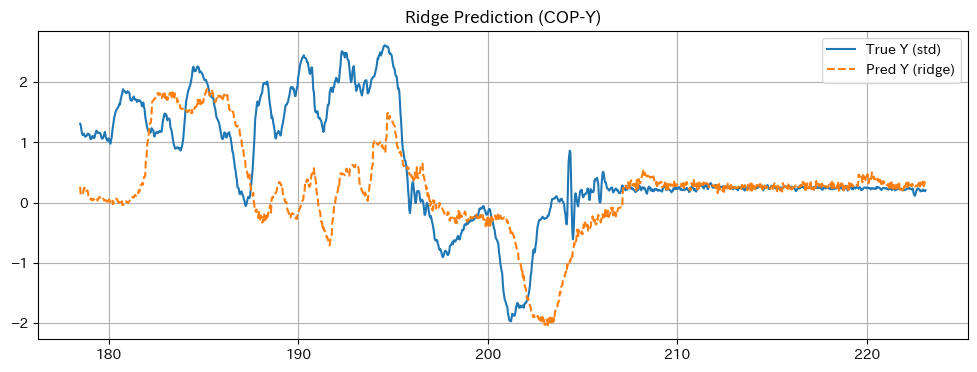

In [108]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ====== 1. 入力と出力 ======
X = X_aligned_std        # 入力：補正後モドキ
Y = X_true_std           # 出力：本物COP（標準化後）
t = time_clean

# 時系列のためシャッフルしない分割
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
# ====== 5. 時系列プロット ======
time_test = t[split:]

# ====== 2. Ridge 回帰 ======
ridge = Ridge(alpha=1.0)   # とりあえず1.0でOK（後でチューニング）
ridge.fit(X_train, Y_train)

# ====== 3. 予測 ======
Y_pred_test = ridge.predict(X_test)

# ====== 4. テスト誤差 ======
mse_x = mean_squared_error(Y_test[:,0], Y_pred_test[:,0])
mse_y = mean_squared_error(Y_test[:,1], Y_pred_test[:,1])

print("MSE COP X:", mse_x)
print("MSE COP Y:", mse_y)


plt.figure(figsize=(12,4))
plt.plot(time_test, Y_test[:,0], label="True X (std)")
plt.plot(time_test, Y_pred_test[:,0], label="Pred X (ridge)", linestyle='--')
plt.title("Ridge Prediction (COP-X)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(time_test, Y_test[:,1], label="True Y (std)")
plt.plot(time_test, Y_pred_test[:,1], label="Pred Y (ridge)", linestyle='--')
plt.title("Ridge Prediction (COP-Y)")
plt.grid(True)
plt.legend()
plt.show()


In [110]:
# === Ridge 回帰の学習結果を確認 ===

print("==== Ridge Model Summary ====")

# バイアス項
print("\nIntercept (bias):")
print(ridge.intercept_)

# 係数（重み）
print("\nCoefficients (W):")
print(ridge.coef_)

# 係数の大きさ（L2ノルム）
coef_norm = np.linalg.norm(ridge.coef_)
print("\nL2 norm of coefficients:", coef_norm)

# 各出力（COP-X, COP-Y）ごとに重要度の大きい特徴Top10
for target in range(ridge.coef_.shape[0]):
    print(f"\n--- Top 10 important features for target {target} ---")
    coef = ridge.coef_[target]
    
    # 絶対値が大きい順に並べる
    top_idx = np.argsort(np.abs(coef))[::-1][:10]
    for idx in top_idx:
        print(f"Feature {idx:3d} | coef={coef[idx]:.4f}")


==== Ridge Model Summary ====

Intercept (bias):
[0.56018702 0.8470538 ]

Coefficients (W):
[[ 0.5296967  -0.19075451]
 [-0.0468838   1.54861706]]

L2 norm of coefficients: 1.6484473837848026

--- Top 10 important features for target 0 ---
Feature   0 | coef=0.5297
Feature   1 | coef=-0.1908

--- Top 10 important features for target 1 ---
Feature   1 | coef=1.5486
Feature   0 | coef=-0.0469


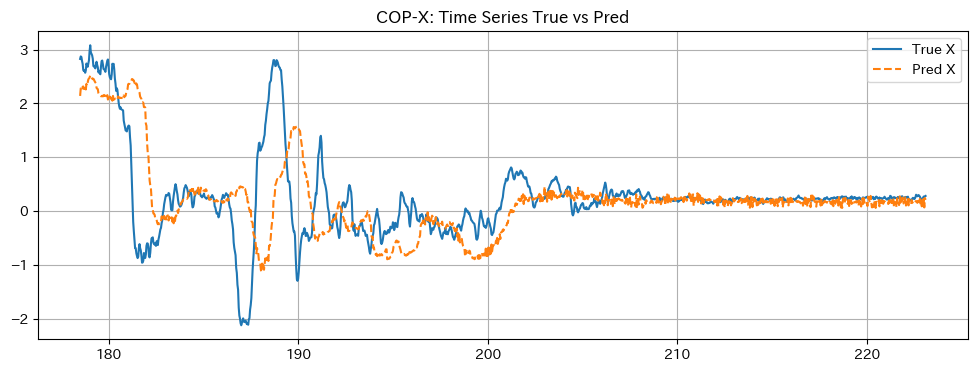

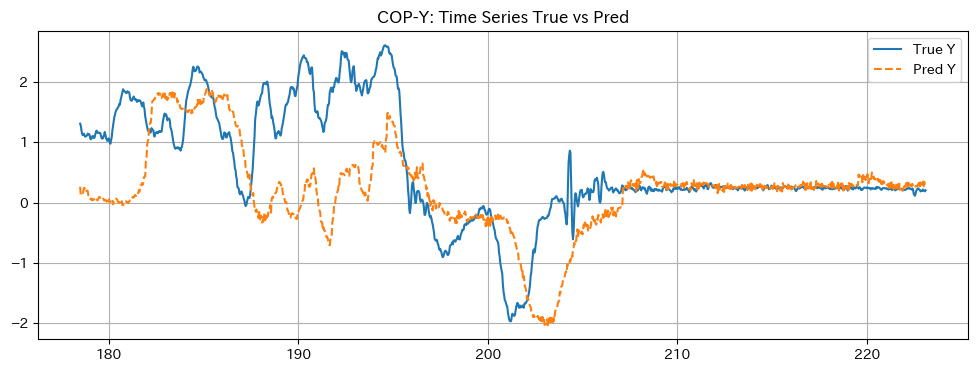

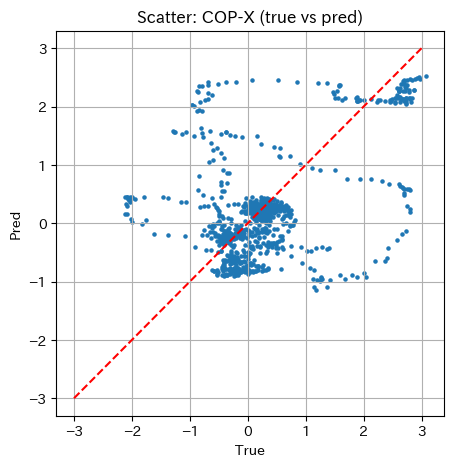

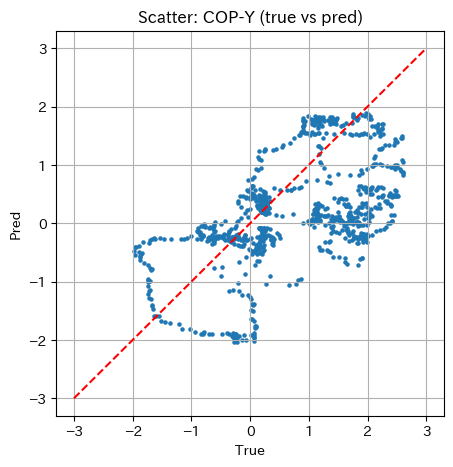

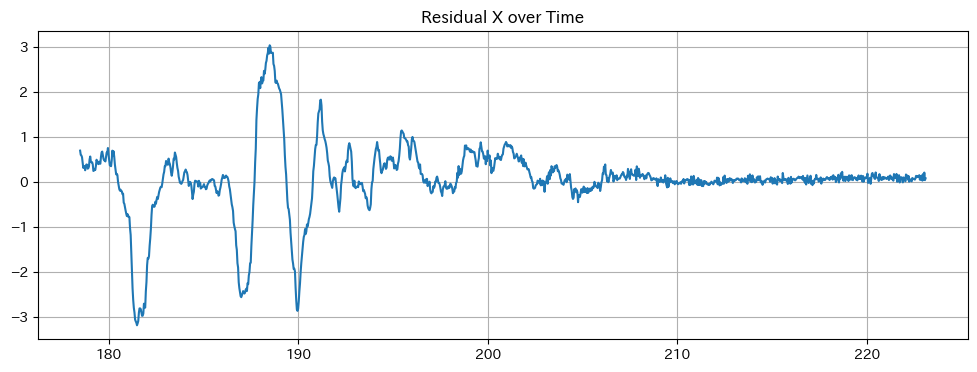

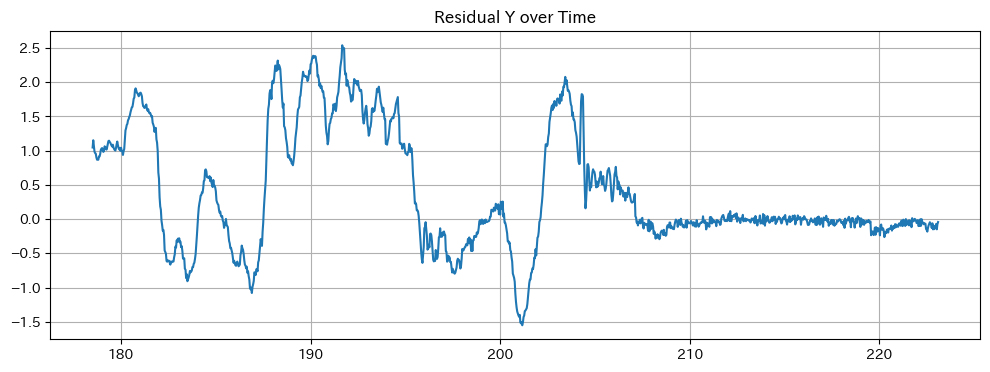

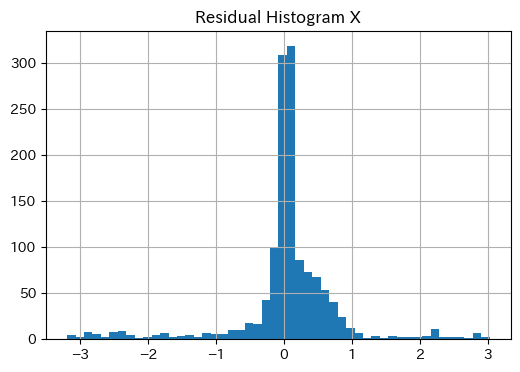

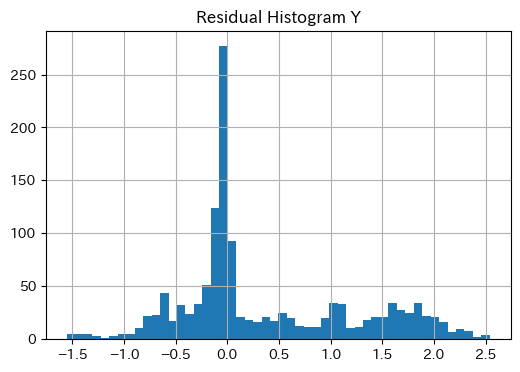

=== 数値評価 ===
MSE_X = 0.626,    R2_X = 0.013
MSE_Y = 0.881,    R2_Y = -0.001


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score



# ======= ① 時系列プロット =======
plt.figure(figsize=(12,4))
plt.plot(time_test, true_x, label="True X")
plt.plot(time_test, pred_x, label="Pred X", linestyle='--')
plt.title("COP-X: Time Series True vs Pred")
plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(time_test, true_y, label="True Y")
plt.plot(time_test, pred_y, label="Pred Y", linestyle='--')
plt.title("COP-Y: Time Series True vs Pred")
plt.grid(True); plt.legend()
plt.show()

# ======= ② 散布図（真値 vs 予測） =======
plt.figure(figsize=(5,5))
plt.scatter(true_x, pred_x, s=5)
plt.plot([-3,3], [-3,3], 'r--')
plt.title("Scatter: COP-X (true vs pred)")
plt.xlabel("True"); plt.ylabel("Pred")
plt.grid(True)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(true_y, pred_y, s=5)
plt.plot([-3,3], [-3,3], 'r--')
plt.title("Scatter: COP-Y (true vs pred)")
plt.xlabel("True"); plt.ylabel("Pred")
plt.grid(True)
plt.show()

# ======= ③ 残差の時系列 =======
res_x = true_x - pred_x
res_y = true_y - pred_y

plt.figure(figsize=(12,4))
plt.plot(time_test, res_x)
plt.title("Residual X over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(time_test, res_y)
plt.title("Residual Y over Time")
plt.grid(True)
plt.show()

# ======= ④ 残差のヒストグラム =======
plt.figure(figsize=(6,4))
plt.hist(res_x, bins=50)
plt.title("Residual Histogram X")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(res_y, bins=50)
plt.title("Residual Histogram Y")
plt.grid(True)
plt.show()

# ======= ⑤ 数値評価 =======
mse_x = mean_squared_error(true_x, pred_x)
mse_y = mean_squared_error(true_y, pred_y)
r2_x  = r2_score(true_x, pred_x)
r2_y  = r2_score(true_y, pred_y)

print("=== 数値評価 ===")
print(f"MSE_X = {mse_x:.3f},    R2_X = {r2_x:.3f}")
print(f"MSE_Y = {mse_y:.3f},    R2_Y = {r2_y:.3f}")
